In [1]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
tf.test.is_built_with_cuda()

True

# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os.path as op
import pickle

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model,Sequential,load_model
from keras.layers import Input, Embedding
from keras.layers import Dense, Bidirectional
from keras.layers.recurrent import LSTM
import keras.metrics as metrics
import itertools
from tensorflow.python.keras.utils.data_utils import Sequence
from decimal import Decimal
from keras import backend as K
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense

# Data Fetching

In [3]:
A1=np.empty((0,5),dtype='float32')
U1=np.empty((0,7),dtype='float32')
node=['150','149','147','144','142','140','136','61']
mon=['Apr','Mar','Aug','Jun','Jul','Sep','May','Oct']
for j in node:
  for i in mon:
    inp= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[1,2,3,15,16])
    out= pd.read_csv('../../../data_gkv/AT510_Node_'+str(j)+'_'+str(i)+'19_OutputFile.csv',usecols=[5,6,7,8,17,18,19])
    
    inp=np.array(inp,dtype='float32')
    out=np.array(out,dtype='float32')
    
    A1=np.append(A1, inp, axis=0)
    U1=np.append(U1, out, axis=0)

print(A1)
print(U1)


[[1.50000e+02 1.90401e+05 7.25000e+02 2.75500e+01 8.03900e+01]
 [1.50000e+02 1.90401e+05 8.25000e+02 2.75600e+01 8.03300e+01]
 [1.50000e+02 1.90401e+05 9.25000e+02 2.75800e+01 8.02400e+01]
 ...
 [6.10000e+01 1.91020e+05 1.94532e+05 2.93700e+01 7.52100e+01]
 [6.10000e+01 1.91020e+05 1.94632e+05 2.93500e+01 7.52700e+01]
 [6.10000e+01 1.91020e+05 1.94732e+05 2.93400e+01 7.53000e+01]]
[[ 28.     3.   -52.   ...  16.97  19.63  20.06]
 [ 28.    15.   -53.   ...  16.63  19.57  23.06]
 [ 31.    16.   -55.   ...  17.24  19.98  20.24]
 ...
 [ 76.    12.   -76.   ...   3.47   3.95   4.35]
 [ 75.    13.   -76.   ...   3.88   4.33   4.42]
 [ 76.    12.   -75.   ...   3.46   4.07   4.28]]


# Min Max Scaler

In [4]:
from sklearn.decomposition import SparsePCA
import warnings
scaler_obj1=SparsePCA()
scaler_obj2=SparsePCA()
X1=scaler_obj1.fit_transform(A1)
Y1=scaler_obj2.fit_transform(U1)

warnings.filterwarnings(action='ignore', category=UserWarning)


X1=X1[:,np.newaxis,:]
Y1=Y1[:,np.newaxis,:]

In [5]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Model

In [6]:
inp=keras.Input(shape=(1,5))

l=keras.layers.Conv1D(16,1,padding="same",activation="tanh",kernel_initializer="glorot_uniform")(inp)
 
output = keras.layers.Conv1D(7,4,padding="same",activation='sigmoid')(l)

model1=keras.Model(inputs=inp,outputs=output)
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy',metrics=['accuracy','mse','mae',rmse])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 5)]            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 16)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 7)              455       
                                                                 
Total params: 551
Trainable params: 551
Non-trainable params: 0
_________________________________________________________________


In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

history1 = model1.fit(x_train,y_train,batch_size=256,epochs=50, validation_data=(x_test, y_test),verbose = 2, shuffle= False)

Epoch 1/50
5070/5070 - 132s - loss: -7.6008e+00 - accuracy: 0.1323 - mse: 2026000128.0000 - mae: 93.4407 - rmse: 189.2681 - val_loss: -7.7411e-02 - val_accuracy: 0.1347 - val_mse: 1403856.8750 - val_mae: 73.6462 - val_rmse: 139.6765 - 132s/epoch - 26ms/step
Epoch 2/50
5070/5070 - 80s - loss: -1.1697e+01 - accuracy: 0.1344 - mse: 2026000128.0000 - mae: 93.4300 - rmse: 189.2609 - val_loss: -3.4081e+00 - val_accuracy: 0.1352 - val_mse: 1403855.3750 - val_mae: 73.6374 - val_rmse: 139.6711 - 80s/epoch - 16ms/step
Epoch 3/50
5070/5070 - 80s - loss: -1.4041e+01 - accuracy: 0.1349 - mse: 2026000128.0000 - mae: 93.4219 - rmse: 189.2561 - val_loss: -6.3163e+00 - val_accuracy: 0.1354 - val_mse: 1403854.1250 - val_mae: 73.6305 - val_rmse: 139.6671 - 80s/epoch - 16ms/step
Epoch 4/50
5070/5070 - 80s - loss: -1.6811e+01 - accuracy: 0.1332 - mse: 2026000128.0000 - mae: 93.4158 - rmse: 189.2522 - val_loss: -9.1781e+00 - val_accuracy: 0.1325 - val_mse: 1403853.3750 - val_mae: 73.6249 - val_rmse: 139.663

Epoch 33/50
5070/5070 - 49s - loss: -9.7531e+01 - accuracy: 0.3133 - mse: 2026000128.0000 - mae: 93.3488 - rmse: 189.2141 - val_loss: -9.1799e+01 - val_accuracy: 0.3128 - val_mse: 1403843.6250 - val_mae: 73.5600 - val_rmse: 139.6263 - 49s/epoch - 10ms/step
Epoch 34/50
5070/5070 - 50s - loss: -1.0027e+02 - accuracy: 0.3133 - mse: 2026000128.0000 - mae: 93.3477 - rmse: 189.2138 - val_loss: -9.4636e+01 - val_accuracy: 0.3128 - val_mse: 1403843.6250 - val_mae: 73.5590 - val_rmse: 139.6260 - 50s/epoch - 10ms/step
Epoch 35/50
5070/5070 - 50s - loss: -1.0302e+02 - accuracy: 0.3133 - mse: 2026000128.0000 - mae: 93.3467 - rmse: 189.2136 - val_loss: -9.7473e+01 - val_accuracy: 0.3128 - val_mse: 1403843.6250 - val_mae: 73.5579 - val_rmse: 139.6257 - 50s/epoch - 10ms/step
Epoch 36/50
5070/5070 - 50s - loss: -1.0577e+02 - accuracy: 0.3133 - mse: 2026000128.0000 - mae: 93.3456 - rmse: 189.2133 - val_loss: -1.0031e+02 - val_accuracy: 0.3128 - val_mse: 1403843.3750 - val_mae: 73.5569 - val_rmse: 139.6

In [8]:
model1.evaluate(x_test,y_test)

13518/13518 [==============================] - 99s 7ms/step - loss: -140.0141 - accuracy: 0.3129 - mse: 1403845.8750 - mae: 73.5453 - rmse: 139.6234


[-140.01406860351562,
 0.3128734827041626,
 1403845.875,
 73.54534912109375,
 139.62342834472656]

# Saving Model as File

In [9]:
model1.evaluate(x_train,y_train)

40554/40554 [==============================] - 306s 8ms/step - loss: -145.5569 - accuracy: 0.3133 - mse: 2025999232.0000 - mae: 93.3334 - rmse: 189.2106


[-145.55694580078125,
 0.31328240036964417,
 2025999232.0,
 93.33340454101562,
 189.2106475830078]

In [10]:
df1=pd.DataFrame(history1.history['loss'],columns=["Loss"])
df1=df1.join(pd.DataFrame(history1.history["val_loss"],columns=["Val Loss"]))
df1=df1.join(pd.DataFrame(history1.history["accuracy"],columns=['Accuracy']))
df1=df1.join(pd.DataFrame(history1.history["val_accuracy"],columns=['Val Accuracy']))
df1=df1.join(pd.DataFrame(history1.history["mse"],columns=['MSE']))
df1=df1.join(pd.DataFrame(history1.history["val_mse"],columns=['Val MSE']))
df1=df1.join(pd.DataFrame(history1.history["mae"],columns=['MAE']))
df1=df1.join(pd.DataFrame(history1.history["val_mae"],columns=['Val MAE']))
df1=df1.join(pd.DataFrame(history1.history["rmse"],columns=['RMSE']))
df1=df1.join(pd.DataFrame(history1.history["val_mse"],columns=['Val RMSE']))
df1

,Loss,Val Loss,Accuracy,Val Accuracy,MSE,Val MSE,MAE,Val MAE,RMSE,Val RMSE
0,-7.600832,-0.077411,0.132305,0.134736,2.026000e+09,1403856.875,93.440720,73.646172,189.268143,1403856.875
1,-11.697382,-3.408147,0.134426,0.135249,2.026000e+09,1403855.375,93.429970,73.637375,189.260864,1403855.375
2,-14.040551,-6.316311,0.134888,0.135356,2.026000e+09,1403854.125,93.421921,73.630455,189.256073,1403854.125
3,-16.810745,-9.178061,0.133242,0.132494,2.026000e+09,1403853.375,93.415764,73.624908,189.252167,1403853.375
4,-19.562893,-12.022623,0.130678,0.127697,2.026000e+09,1403851.875,93.410713,73.620117,189.249008,1403851.875
5,-22.306133,-14.871655,0.126623,0.125112,2.026000e+09,1403851.125,93.406265,73.615891,189.245895,1403851.125
6,-25.048990,-17.699781,0.124584,0.124269,2.026000e+09,1403850.625,93.402153,73.611908,189.243011,1403850.625
7,-27.786900,-20.544609,0.123900,0.123510,2.026000e+09,1403850.125,93.398384,73.608383,189.240265,1403850.125
8,-31.234846,-23.380016,0.206354,0.288387,2.026000e+09,1403849.750,93.395134,73.605186,189.237656,1403849.750
9,-33.998608,-26.277956,0.293659,0.299918,2.026000e+09,1403849.125,93.391922,73.602097,189.235260,1403849.125


In [11]:
df1.to_excel("GRU_tanh_mse.xlsx")

In [12]:
model_json = model1.to_json()
with open("cnn_relu.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("cnn_relu.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

from keras.models import model_from_json
json_file = open('cnn_relu.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("cnn_relu.h5")
print("Loaded model from disk")
loaded_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mse',metrics=['accuracy','mse','mae',rmse])

Loaded model from disk


In [14]:
loaded_model.evaluate(x_train, y_train, verbose=0)

[2025999232.0,
 0.31328240036964417,
 2025999232.0,
 93.33340454101562,
 189.2106475830078]

In [15]:
loaded_model.evaluate(x_test, y_test, verbose=0)

[1403845.875,
 0.3128734827041626,
 1403845.875,
 73.54534912109375,
 139.62342834472656]

# Error Analysis

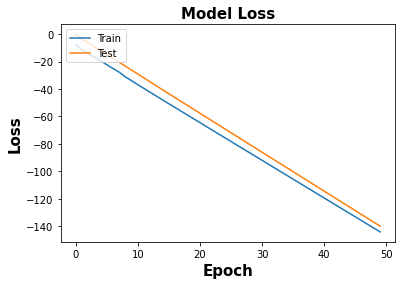

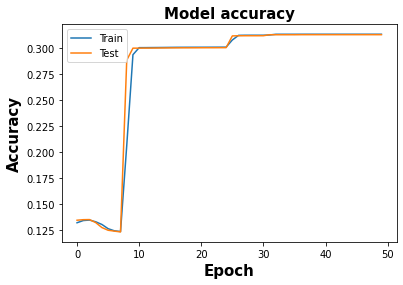

In [16]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss',fontweight ='bold',fontsize = 15)
plt.ylabel('Loss',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy',fontweight ='bold',fontsize = 15)
plt.ylabel('Accuracy',fontweight ='bold',fontsize = 15)
plt.xlabel('Epoch',fontweight ='bold',fontsize = 15)
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.25, random_state=42)

y_test_pred=loaded_model.predict(x_test)
y_test_pred

array([[[2.9863697e-01, 1.5669495e-01, 4.7337441e-04, ...,
         7.3891573e-18, 2.2201036e-01, 1.8466166e-01]],

       [[2.9863697e-01, 1.5669495e-01, 4.7337441e-04, ...,
         7.3891573e-18, 2.2201036e-01, 1.8466166e-01]],

       [[2.9863697e-01, 1.5669495e-01, 4.7337441e-04, ...,
         7.3891573e-18, 2.2201036e-01, 1.8466166e-01]],

       ...,

       [[6.7639685e-01, 7.3944885e-01, 9.9957472e-01, ...,
         1.0000000e+00, 7.8101441e-02, 3.0872941e-02]],

       [[2.9863697e-01, 1.5669495e-01, 4.7337441e-04, ...,
         7.3891573e-18, 2.2201036e-01, 1.8466166e-01]],

       [[2.9863697e-01, 1.5669495e-01, 4.7337441e-04, ...,
         7.3891573e-18, 2.2201036e-01, 1.8466166e-01]]], dtype=float32)

In [18]:
y_test

array([[[-5.4707150e+01,  3.0351229e+01,  2.6544733e+02, ...,
         -3.1806244e+01, -5.8596706e-01, -3.9942199e-01]],

       [[-4.0422195e+01, -3.2006611e+01,  3.9725319e+01, ...,
         -1.6595110e+01, -4.2555341e-01,  4.5112044e-01]],

       [[-5.2611900e+01,  6.3103738e+00, -5.3949774e+02, ...,
          2.1971800e+01,  4.6926007e+00,  9.8132938e-01]],

       ...,

       [[-8.7108231e+01, -3.0540722e+01, -4.3651901e+02, ...,
          6.8366714e+01,  3.2034805e-01,  1.0517381e+00]],

       [[-5.0692768e+01,  1.9452883e+01,  1.6842407e+02, ...,
         -2.2491724e+01, -1.5624888e+00,  2.1897414e-01]],

       [[-9.4654129e+01, -6.0080070e+01,  1.5260393e+02, ...,
         -2.9023485e+01, -8.3189094e-01, -4.2029378e-01]]], dtype=float32)

In [19]:
y_test=y_test[:,0]
y_test_pred=y_test_pred[:,0]

In [20]:
from numpy import savetxt
savetxt('cnn_y_test_pred.csv', y_test_pred[:1001], delimiter=',')

In [21]:
from numpy import savetxt
savetxt('cnn_y_test.csv', y_test[:1001], delimiter=',')

In [ ]:
#completed